# Classification using Cyclic Boosting

In [1]:
!pip install cyclic-boosting

In [2]:
import pandas as pd
import numpy as np


from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

from cyclic_boosting import flags, common_smoothers, observers, binning
from cyclic_boosting.plots import plot_analysis
from cyclic_boosting.pipelines import pipeline_CBClassifier

Let's load the adult census income dataset from OpenML

In [3]:
from sklearn.datasets import fetch_openml
data = fetch_openml(data_id=1590)


# Read the DataFrame, first using the feature data
df = pd.DataFrame(data.data, columns=data.feature_names)# Add a target column, and fill it with the target data
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States
48838,40.0,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
48839,58.0,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States
48840,22.0,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States


For convenience we split the colums into two groups, categorical and continuous

In [4]:
cols_categorical = ['workclass', 'education', 'marital-status', 'occupation',
                    'relationship', 'race', 'sex', 'native-country']
cols_noncat = [n for n in df.columns if n not in cols_categorical]

Adding the target column to the dataframe and convert to 0 and 1

In [5]:
df['target'] = data.target.eq('>50K').mul(1)

In [6]:
cols_noncat+cols_categorical

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [7]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'target'],
      dtype='object')

# Prepare the data

The data has to be prepared for the training. We want to convert the categorical variables into numerical values using the scikit-learn OrdinalEncoder (guess, who contributed this 😜).

In [8]:
def prepare_data(df):
    cols_categorical = ['workclass', 'education', 'marital-status', 'occupation',
                    'relationship', 'race', 'sex', 'native-country']
  
    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
      
    df[cols_categorical] = enc.fit_transform(df[cols_categorical])

    y = np.asarray(df['target'])
    X = df.drop(columns='target')

    return X, y

In [9]:
X, y = prepare_data(df)

# Set the feature properties

We need to tell Cyclic Boosting which feature to use and what type of feature these are and how to handle them.

We want the continuous features be `IS_CONTINUOUS` with missing values (very handy, isn't it 😎) and the categorical features to be treated as unordered classes (no neighboring relation as in weekdays for example).

Note: there is next to no feature engineering done here deliberately. Checking the feature carefully, there can be potentially improved a lot by treating the features individually and maybe even combing them into 2D features (see documentation). We just want to get it up-and-running here.

In [10]:
def feature_properties():
    fp = {}

    for col in cols_categorical:
      fp[col] = flags.IS_UNORDERED | flags.HAS_MISSING | flags.MISSING_NOT_LEARNED

    for col in cols_noncat:
      fp[col] = flags.IS_CONTINUOUS | flags.HAS_MISSING | flags.MISSING_NOT_LEARNED
    
    return fp

In [11]:
def get_features():
    features = ['age',
                'fnlwgt',
                'education-num',
                'capital-gain',
                'capital-loss',
                'hours-per-week',
                'workclass',
                'education',
                'marital-status',
                'occupation',
                'relationship',
                'race',
                'sex',
                'native-country']
    return features

# Build the model

The model is implemented as a scikit-learn pipeline, stitching together a Binner and the CB classifier estimator. Most natably, we reduce the number of used bins in all continuous features to 10 instead of 100, should be plenty.

In [12]:

def cb_classifier_model():
    features = get_features()

    fp = feature_properties()

    plobs = [
        observers.PlottingObserver(iteration=-1)
    ]

    CB_pipeline = pipeline_CBClassifier(
        feature_properties=fp,
        feature_groups=features,
        observers=plobs,
        maximal_iterations=50,
        number_of_bins=10,
        smoother_choice=common_smoothers.SmootherChoiceGroupBy(
            use_regression_type=True,
            use_normalization=False,
        ),
    )

    return CB_pipeline

In [13]:
CB_est = cb_classifier_model()

CB_est

Pipeline(steps=[('binning',
                 BinNumberTransformer(feature_properties={'age': 49,
                                                          'capital-gain': 49,
                                                          'capital-loss': 49,
                                                          'education': 52,
                                                          'education-num': 49,
                                                          'fnlwgt': 49,
                                                          'hours-per-week': 49,
                                                          'marital-status': 52,
                                                          'native-country': 52,
                                                          'occupation': 52,
                                                          'race': 52,
                                                          'relationship': 52,
                                                          'sex': 52,
                                                          'workclass': 52},
                                      n_bins=10)),
                ('CB',
                 CBClassifier(feature_groups=['age', 'fnlwgt',...
                                                  'occupation': 52, 'race': 52,
                                                  'relationship': 52, 'sex': 52,
                                                  'workclass': 52},
                              learn_rate=<function half_linear_learn_rate at 0x12302de10>,
                              maximal_iterations=50,
                              minimal_factor_change=0.001,
                              minimal_loss_change=0.001,
                              observers=[<cyclic_boosting.observers.PlottingObserver object at 0x1248f7460>],
                              smoother_choice=<cyclic_boosting.common_smoothers.SmootherChoiceGroupBy object at 0x1248f6650>))])

# The training

In [14]:
%%timeit -r 1
CB_est.fit(X.copy(), y)

1.18 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


That's it, now we did the training, that was fast and easy, isn't it?

## Evaluation

Now we can do the inference for all samples. Note that we get proper probabilities for all target categories using predict_proba, which is really nice! 

In [15]:
yhat = CB_est.predict_proba(X.copy())

With this we can calculate the mean absolute deviation

In [16]:
mad = np.nanmean(np.abs(y - yhat[:,0]))
mad

0.7789289483476862

Or the scikit-learn in-sample score (yes, you should do some cross-validation for a real world problem 😬)

In [17]:
# in-sample score
CB_est.score(X, y)

0.8414888825191433

# Some nice plots

Cyclic Boosting has some useful reporting of the traning included. We can create a pdf with this code

In [18]:
def plot_CB(filename, plobs, binner):
    for i, p in enumerate(plobs):
        plot_analysis(
            plot_observer=p,
            file_obj=filename + "_{}".format(i),
            use_tightlayout=False,
            binners=[binner]
        )

In [19]:
plot_CB('analysis_CB_iterlast',
         [CB_est[-1].observers[-1]], CB_est[-2])



You will now find a pdf file containing all sorts of plots. They are explained in the documentation of Cyclic Boosting.

Just as an eye candy, lets plot the separation of of both classes.

In [20]:
df['pred'] = yhat[:,0]

<AxesSubplot: >

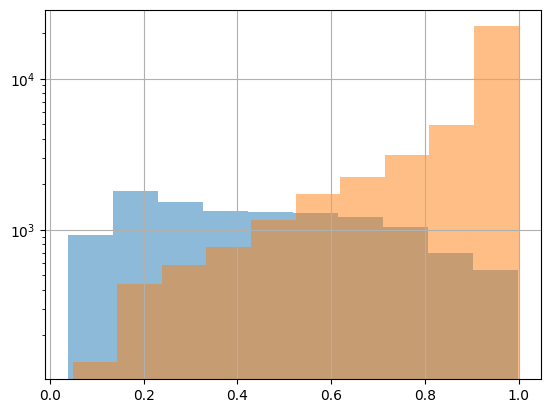

In [21]:
ax = df[df['target']>0].pred.hist(log=True, alpha = 0.5)
df[df['target']==0].pred.hist(log=True, alpha = 0.5, ax=ax)

You see, it is easy to do a classification using Cyclic Boosting and it works!